# Imports

In [1]:
import pandas as pd
import pathlib
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Flatten, Reshape, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, BatchNormalization, LSTM, Dense, Activation, TimeDistributed, Bidirectional, Concatenate, GRU, Masking
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2 as l2_regularization
from tensorflow.keras import metrics as classif_metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

# Data loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define a schema and read parquet data
schema = pa.schema([('series_id',pa.string()),
          ('step',pa.int32()),
          ('timestamp', pa.timestamp('ms',tz='UTC')),
          ('anglez',pa.float32()),
          ('enmo',pa.float32())
         ])

In [6]:
# Reading clean data (2 classes / no NAs)
DATA_DIR = pathlib.Path("/content/drive/MyDrive/M2/Datasets/Sleep_States")

DATASET_PATH = DATA_DIR.joinpath("data_series_clean.zip")
LABELS_PATH = DATA_DIR.joinpath("train_events.csv")
COMPETITION_SERIES_PATH = DATA_DIR.joinpath("test_series.parquet")

dataset = pd.read_csv(DATASET_PATH)
labels = pd.read_csv(LABELS_PATH)

test_series = pq.read_table(COMPETITION_SERIES_PATH, schema=schema)
test_series = test_series.to_pandas()

# Functions

In [16]:
def get_missing_data_column(df, missing_col, id_col, value_col):
  '''Returns the time series that contain missing values on missing_col for each value_col.

  Parameters
  ----------
  df : pandas dataframe
    your data
  missing_col : string
    column to inspect for NA
  id_col : string
    the column used as id
  value_col : string
    target column for each id

  Output
  ------
  dictionary
    keys : string
    values : list<string>
  '''

  missing_time_mask = df[missing_col].isna()
  missing_time_df = df[missing_time_mask]

  missing_dict = {}

  for _, row in missing_time_df.iterrows():
    series_id = row[id_col]
    night = row[value_col]

    if series_id not in missing_dict:
        missing_dict[series_id] = []

    missing_dict[series_id].append(night)

  return missing_dict

In [17]:
def encode_output(df, output_col='event'):
  """Encodes the categorical output column values as integers.

  Parameters
  ----------
  df: pandas dataframe
    your data.
  output_col: string, optional, default=event
    name of the column to be encoded.

  Output
  ------
  None
  """
  unique_values = list(df[output_col].unique())
  mapping = {value: index for index, value in enumerate(unique_values)}
  df[output_col] = df[output_col].replace(mapping)
  return mapping

In [18]:
def add_padding(df, column, length, number_features, output_class=None):
  '''Creates empty series observations to be used as padding.

  Parameters
  ----------
  df: pandas dataframe
    data
  column: string
    name of the time column (to be used for padding).
  length: int
    length of the longest time series in the dataset.
  number_features: int
    number of features to be generated for each observation.
  output_class: int
    if defined, it represents the class value of the padded output.

  Output
  ------
  Numpy array
  '''
  # Calculate the number of rows to pad
  pad_rows = length - df[column].max()

  if output_class is None:
    # Create a padding array (We choose (0,0) as neutral values for anglez and enmo)
    padding = np.zeros((pad_rows, number_features))
    # The time feature contains a sequence of numbers
    # padding[:, number_features-1] = np.arange(df[column].max()+1, length+1)
  else:
    padding = np.zeros(pad_rows)

  return padding

In [19]:
def create_dataset(data, features=["enmo", "anglez", "step"], id_feature="series_id", time_feature="step", output_class=None, nb_classes=3):
  """Creates a dataset from a dataframe.

  Parameters
  ----------
  data: pandas dataframe
    original dataframe
  features: list of string, optional, default:["enmo", "anglez", "step"]
    list of features to be kept.
  id_feature: string, optional, default: "series_id"
    name of the feature that is used as id.
  time_feature: string, optional, default: "step
    name of the feature that is used for time (steps) definition.
  output_class: int
    if defined, it represents the class value of the padded output.
  nb_classes: int
    number of classes in classification.

  Output
  ------
  Numpy array of shape (number_timeseries, max_timeseries_length, number_features)
  """
  encoder = LabelEncoder()

  # Find the maximum length of the time series
  length = data[time_feature].max()

  # Initialize arrays to store data
  series_data = []

  for series_id, df in data.groupby(id_feature):
    if output_class is None:
      # Case of input_data features
      temp_serie = df.loc[:, features].to_numpy()
    else:
      # Case of output_data feature
      temp_serie = df[features[0]].to_numpy()

    if df[time_feature].max() < length:
      # We pad the time series to the longest time series
      padding = add_padding(df, time_feature, length, len(features), output_class)

      # Concatenate the padding array to the temp_serie
      temp_serie = np.concatenate((temp_serie, padding), axis=0)

    if not output_class is None:
      temp_serie = to_categorical(temp_serie, num_classes=nb_classes)

    series_data.append(temp_serie)

  series_data = np.array(series_data)

  # Generalize this if/else later for nb_class<>3
  if output_class is None:
    mask_data = np.all(series_data == np.array([0, 0, 0]), axis=-1)
  else:
    mask_data = np.all(series_data == np.array([0, 0, 1]), axis=-1)

  mask_data = np.logical_not(mask_data)

  return series_data, mask_data

In [20]:
def split_dataset(inputs, outputs, proportions=[25, 5, 5], seed=1):
  '''Creates training, validation and test datasets from the original dataset.

  Parameters
  ----------

  inputs: numpy array
    dataset of inputs
  outputs: numpy array
    dataset of outputs
  proportions: list of integers, optional, default=[25, 5, 5]
    number of samples in train, test, val
  seed: int, optional, default=1
    seed for reproductibility

  Outputs
  -------
  ((train_input, train_output), (test_input, test_output), (val_input, val_output))
  '''
  random.seed(seed)
  np.random.seed(seed)

  num_samples = inputs.shape[0]
  shuffled_indices = np.random.permutation(num_samples)

  train_indices = shuffled_indices[:proportions[0]]
  test_indices = shuffled_indices[proportions[0]:proportions[0]+proportions[1]]
  validation_indices = shuffled_indices[proportions[0]+proportions[1]:]

  train_input = inputs[train_indices]
  train_output = outputs[train_indices]

  test_input = inputs[test_indices]
  test_output = outputs[test_indices]

  validation_input = inputs[validation_indices]
  validation_output = outputs[validation_indices]

  return (train_input, train_output), (test_input, test_output), (validation_input, validation_output), (train_indices, test_indices, validation_indices)

In [21]:
def create_lstm(input_shape, metrics, lr=0.001, loss='sparse_categorical_crossentropy', num_classes=3):
  '''Creates an LSTM model.

  Parameters
  ----------

  input_shape: Tuple(int)
    shape of the input data.
  metrics: list
    list of tensorflow metrics to be used for classification.
  lr: float, optional, default=0.001
    learning rate
  loss: string | tensorflow object (if custom loss), optional, default='sparse_categorical_crossentropy'
    loss function
  num_classes: int
    number of classes for the classification task

  Ouput
  -----
  Tensorflow Model object
  '''
  input_layer = Input(shape=input_shape)
  masked_input = Masking(mask_value=0.)(input_layer)

  l1 = LSTM(60, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2_regularization(0.01), recurrent_regularizer=l2_regularization(0.01))(masked_input)
  l2 = Dropout(0.2)(l1)

  l3 = LSTM(60, return_sequences=True, kernel_regularizer=l2_regularization(0.01), recurrent_regularizer=l2_regularization(0.01))(l2)
  l4 = Dropout(0.2)(l3)

  output_layer = Dense(num_classes, activation='softmax')(l4)

  model = Model(inputs=input_layer, outputs=output_layer, name='LSTM')

  optimizer = Adam(learning_rate=lr)
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics, sample_weight_mode="temporal")

  return model

In [22]:
def create_bilstm(input_shape, metrics, lr=0.001, loss='sparse_categorical_crossentropy', num_classes=3):
  '''Creates a BiLSTM model.

  Parameters
  ----------

  input_shape: Tuple(int)
    shape of the input data.
  metrics: list
    list of tensorflow metrics to be used for classification.
  lr: float, optional, default=0.001
    learning rate
  loss: string | tensorflow object (if custom loss), optional, default='sparse_categorical_crossentropy'
    loss function
  num_classes: int
    number of classes for the classification task

  Ouput
  -----
  Tensorflow Model object
  '''
  input_layer = Input(shape=input_shape, name='input_layer')
  masked_input = Masking(mask_value=0.)(input_layer)

  bl1 = Bidirectional(LSTM(units=64, return_sequences=True))(masked_input)

  bl2 = Bidirectional(LSTM(units=32, return_sequences=True))(bl1)

  bl3 = Bidirectional(LSTM(units=16, return_sequences=True))(bl2)

  d1 = Dense(units=128, activation='relu')(bl3)
  d2 = Dropout(0.1)(d1)

  output_layer = Dense(num_classes, activation='softmax')(d2)

  model = Model(inputs=input_layer, outputs=output_layer, name="BiLSTM")

  optimizer = Adam(learning_rate=lr)
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics, sample_weight_mode="temporal")

  return model

In [23]:
def create_lstmcnn(input_shape, metrics, lr=0.001, loss='sparse_categorical_crossentropy', num_classes=3):
  '''Creates a CNN-LSTM model.

  Parameters
  ----------

  input_shape: Tuple(int)
    shape of the input data.
  metrics: list
    list of tensorflow metrics to be used for classification.
  lr: float, optional, default=0.001
    learning rate
  loss: string | tensorflow object (if custom loss), optional, default='sparse_categorical_crossentropy'
    loss function
  num_classes: int
    number of classes for the classification task

  Ouput
  -----
  Tensorflow Model object
  '''
  input_layer = Input(shape=input_shape, name='input_layer')
  masked_input = Masking(mask_value=0.)(input_layer)

  # First Conv1D Layer
  x1 = Conv1D(16, kernel_size=512, activation='relu', padding="same")(masked_input)
  x2 = Dropout(0.25)(x1)
  x3 = BatchNormalization()(x2)
  #x = MaxPooling1D(pool_size=2, strides=2, data_format="channels_first")(x)

  # Second Conv1D Layer
  x4 = Conv1D(16, kernel_size=256, activation='relu', padding="same")(x3)
  x5 = Dropout(0.25)(x4)
  x6 = BatchNormalization()(x5)

  # Third Conv1D Layer
  x7 = Conv1D(16, kernel_size=256, activation='relu', padding="same")(x6)
  x8 = Dropout(0.25)(x7)
  x9 = BatchNormalization()(x8)
  #x = MaxPooling1D(pool_size=2, strides=2, data_format="channels_first")(x)

  # Fourth Conv1D Layer
  x10 = Conv1D(16, kernel_size=32, activation='relu', padding="same")(x9)
  x11 = Dropout(0.25)(x10)
  x12 = BatchNormalization()(x11)

  # LSTM Layer
  x13 = LSTM(256, return_sequences=True)(x12)

  # Dense Layer
  x14 = TimeDistributed(Dense(128, activation='relu'))(x13)
  x15 = Dropout(0.25)(x14)
  x16 = BatchNormalization()(x15)

  # Output layer
  output_layer = TimeDistributed(Dense(units=num_classes, activation='softmax'))(x16)

  # Creation of the model
  model = Model(inputs=input_layer, outputs=output_layer, name="CNN-LSTM")

  optimizer = Adam(learning_rate=lr)
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics, sample_weight_mode="temporal")

  return model

In [24]:
def create_bilstmcnn(input_shape, metrics, lr=0.001, loss='sparse_categorical_crossentropy', num_classes=3):
  '''Creates a CNN-BiLSTM model.

  Parameters
  ----------

  input_shape: Tuple(int)
    shape of the input data.
  metrics: list
    list of tensorflow metrics to be used for classification.
  lr: float, optional, default=0.001
    learning rate
  loss: string | tensorflow object (if custom loss), optional, default='sparse_categorical_crossentropy'
    loss function
  num_classes: int
    number of classes for the classification task

  Ouput
  -----
  Tensorflow Model object
  '''
  input_layer = Input(shape=input_shape, name='input_layer')
  masked_input = Masking(mask_value=0.)(input_layer)

  # First Conv1D Layer
  x1 = Conv1D(16, kernel_size=512, activation='relu', padding="same")(masked_input)
  x2 = Dropout(0.25)(x1)
  x3 = BatchNormalization()(x2)
  #x = MaxPooling1D(pool_size=2, strides=2, data_format="channels_first")(x)

  # Second Conv1D Layer
  x4 = Conv1D(16, kernel_size=256, activation='relu', padding="same")(x3)
  x5 = Dropout(0.25)(x4)
  x6 = BatchNormalization()(x5)

  # Third Conv1D Layer
  x7 = Conv1D(16, kernel_size=256, activation='relu', padding="same")(x6)
  x8 = Dropout(0.25)(x7)
  x9 = BatchNormalization()(x8)
  #x = MaxPooling1D(pool_size=2, strides=2, data_format="channels_first")(x)

  # Fourth Conv1D Layer
  x10 = Conv1D(16, kernel_size=32, activation='relu', padding="same")(x9)
  x11 = Dropout(0.25)(x10)
  x12 = BatchNormalization()(x11)

  # LSTM Layer
  bl2 = Bidirectional(LSTM(units=128, return_sequences=True))(x12)

  # Dense Layer
  x14 = TimeDistributed(Dense(128, activation='relu'))(bl2)
  x15 = Dropout(0.25)(x14)
  x16 = BatchNormalization()(x15)

  # Output layer
  output_layer = TimeDistributed(Dense(units=num_classes, activation='softmax'))(x16)

  # Creation of the model
  model = Model(inputs=input_layer, outputs=output_layer, name="CNN-LSTM")

  optimizer = Adam(learning_rate=lr)
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics, sample_weight_mode="temporal")

  return model

In [25]:
def visualize_metric(history, metric_name):
  '''Creates a visualization of the evolution of metric_name during training.

  Parameters
  ----------

  history: result of model.fit()
    logs from model training.
  metric_name: string
    name of the metric attribute in history.

  Ouputs
  ------
  None
  '''
  loss = history.history[metric_name]
  val_loss = history.history[f'val_{metric_name}']

  plt.plot(loss, label=f'{metric_name} (Training)')
  plt.plot(val_loss, label=f'{metric_name} (Validation)')
  plt.title(f'{metric_name} Over Time')
  plt.xlabel('Epoch')
  plt.ylabel(f'{metric_name} ')
  plt.legend()
  plt.show()

# Data Pre-processing

In [26]:
# Returns the mapping dictionary
print(encode_output(dataset))

{'awake': 0, 'sleeping': 1}


In [27]:
# We standardise the columns anglez and enmo
scaler = StandardScaler()
scaler.fit(dataset[['enmo', 'anglez']])
dataset[['enmo', 'anglez']] = scaler.transform(dataset[['enmo', 'anglez']])

In [29]:
clean_input, mask_input = create_dataset(dataset)
clean_output, mask_output = create_dataset(dataset, features=['event'], output_class=2, nb_classes=3)

print(f"Input shape : {clean_input.shape}")
print(f"Output shape : {clean_output.shape}")

Input shape : (35, 634680, 3)
Output shape : (35, 634680, 3)


In [ ]:
flattened_data = clean_output.reshape(-1, 3)
unique_arrays, counts  = np.unique(flattened_data, axis=0, return_counts=True)
for unique_array, count in zip(unique_arrays, counts):
    print("Array unique :", unique_array)
    print("Nombre d'occurrences :", count)

Array unique : [0. 0. 1.]
Nombre d'occurrences : 9048240
Array unique : [0. 1. 0.]
Nombre d'occurrences : 4504884
Array unique : [1. 0. 0.]
Nombre d'occurrences : 8660676


In [31]:
train_data, test_data, val_data, indices = split_dataset(clean_input, clean_output)

In [32]:
mask_train = mask_input[indices[0]]
mask_test = mask_input[indices[1]]
mask_val = mask_input[indices[2]]

In [ ]:
#del dataset

# Data Vizualisation

Credits for the inspiration of some of the graphics and visualizations : **KELLI BELCHER** (https://www.kaggle.com/code/kellibelcher/time-series-classification-with-lstms-sensor-eda)

In [ ]:
print(f"Missing values = {dataset.isna().sum().sum()}, Duplicates = {dataset.duplicated().sum()}.\n")

Missing values = 0, Duplicates = 0.



In [ ]:
# {'awake': 0, 'sleeping': 1}

# We create two separate dataframe stats for each event value (awake, asleep)
subset0 = dataset[dataset.event==0].describe().reset_index()
subset1 = dataset[dataset.event==1].describe().reset_index()

subset0['event'] = 0
subset1['event'] = 1

# We join the dataframes in one single description and show it
stats_df = pd.concat([subset0, subset1], axis=0).set_index(['index','event'])

stats_df.index = stats_df.index.set_names(['','Event'])
stats_df = stats_df.reindex([('count', 0),('count', 1),( 'mean', 0),( 'mean', 1),
               (  'std', 0), (  'std', 1),(  'min', 0),(  'min', 1),
               (  '25%', 0), (  '25%', 1),(  '50%', 0),(  '50%', 1),
               (  '75%', 0),(  '75%', 1),(  'max', 0),(  'max', 1)])

display(stats_df.style.format('{:,.2f}').background_gradient(subset=(stats_df.index[2:], stats_df.columns[:]), cmap='GnBu', axis=0))

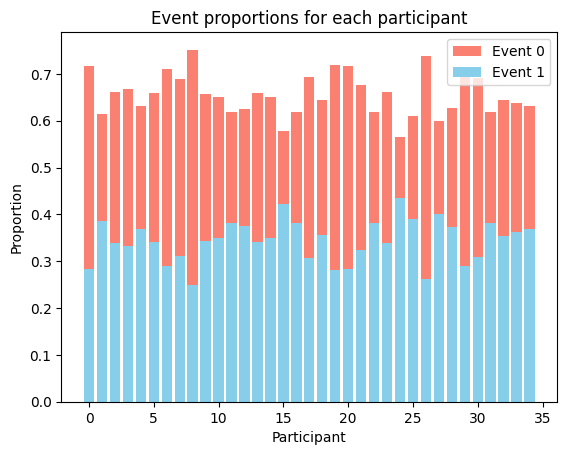

In [ ]:
proportions = dataset.groupby('series_id')['event'].value_counts(normalize=True).unstack().fillna(0)

fig, ax = plt.subplots()

participants = range(len(proportions))

ax.bar(participants, proportions[0], color='salmon')
ax.bar(participants, proportions[1], color='skyblue')

ax.set_ylabel('Proportion')
ax.set_xlabel('Participant')
ax.set_title('Event proportions for each participant')
ax.legend(['Event 0', 'Event 1'], loc='upper right')

plt.show()

In [ ]:
color=px.colors.qualitative.Plotly

features = ['anglez', 'enmo']
titles = [f'Distribution of feature {features[i]}'for i in range(len(features))]

fig = make_subplots(rows=2, cols=1,
                    subplot_titles=titles, column_widths=[0.5])
legend=True
for i, feature in enumerate(features):
  if i != 0:
        legend=False
  for j in range(0,2):
    hist_data=dataset[dataset.event==j][feature]
    density=gaussian_kde(dataset=hist_data)
    x=np.arange(hist_data.min(), hist_data.max())
    density.covariance_factor = lambda: 4
    density._compute_covariance()
    kde_curve=density(x)
    fig.append_trace(go.Scatter(x=x, y=kde_curve, marker_color=color[j],
                                fill='tozeroy', name='State {}'.format(j),
                                hovertemplate='Density = %{y:.5f} at %{x}',
                                showlegend=legend),
                      row=i+1, col=1)
    fig.update_yaxes(title="Density",row=i+1, col=1)

fig.show()

In [ ]:
print(f"Number of (enmo, anglez) = (0, 0) combinations : {len(list(dataset[(dataset['anglez'] == 0) & (dataset['enmo'] == 0)].index))}")

Number of (enmo, anglez) = (0, 0) combinations : 0


# LSTM architecture

In [12]:
input_shape = (634680, 3)
num_classes = 3
learning_rate=0.001
loss='categorical_crossentropy'
metrics=['accuracy', classif_metrics.AUC(name = 'auc')]

lstm_model=create_lstm(input_shape, metrics, learning_rate, loss, num_classes)
lstm_model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 634680, 3)]       0         
                                                                 
 masking (Masking)           (None, 634680, 3)         0         
                                                                 
 lstm (LSTM)                 (None, 634680, 60)        15360     
                                                                 
 dropout (Dropout)           (None, 634680, 60)        0         
                                                                 
 lstm_1 (LSTM)               (None, 634680, 60)        29040     
                                                                 
 dropout_1 (Dropout)         (None, 634680, 60)        0         
                                                                 
 dense (Dense)               (None, 634680, 3)         183    

In [ ]:
lr = ReduceLROnPlateau(monitor='val_auc', factor=0.4,  patience=3, verbose=True)
es = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True, verbose=True)

In [ ]:
lstm_history = lstm_model.fit(
    train_data[0],
    train_data[1],
    epochs=20,
    batch_size=4,
    validation_data=val_data,
    sample_weight=mask_train,
    callbacks=[es,lr]
)

Epoch 1/20
7/7 [==============================] - 185s 25s/step - loss: 3.1931 - accuracy: 0.3934 - auc: 0.5767 - val_loss: 3.0065 - val_accuracy: 0.3513 - val_auc: 0.5936 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - 174s 25s/step - loss: 2.8945 - accuracy: 0.3902 - auc: 0.5908 - val_loss: 2.7031 - val_accuracy: 0.3511 - val_auc: 0.6039 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - 175s 25s/step - loss: 2.6257 - accuracy: 0.3949 - auc: 0.5952 - val_loss: 2.4676 - val_accuracy: 0.4540 - val_auc: 0.6296 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - 173s 25s/step - loss: 2.4046 - accuracy: 0.3886 - auc: 0.5912 - val_loss: 2.2739 - val_accuracy: 0.3513 - val_auc: 0.5772 - lr: 0.0010
Epoch 5/20
7/7 [==============================] - 177s 26s/step - loss: 2.2080 - accuracy: 0.3981 - auc: 0.5980 - val_loss: 2.0876 - val_accuracy: 0.4539 - val_auc: 0.6294 - lr: 0.0010
Epoch 6/20
7/7 [==============================] - 175s 25s/step - loss: 2.0

In [ ]:
# To save the model
lstm_model.save('lstm_24102023.h5')

with open('lstm_history_24102023.pkl', 'wb') as file:
    pickle.dump(lstm_history.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
# To load the model if already trained

# lstm_model = load_model('lstm_24102023.h5')
# with open('lstm_history_24102023.pkl', 'rb') as file:
#    lstm_history = pickle.load(file)

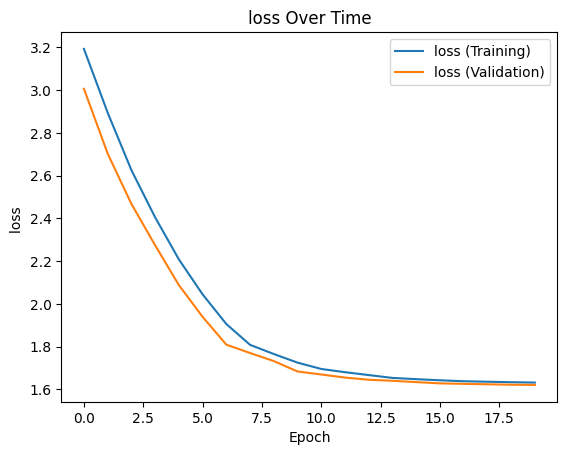

In [ ]:
visualize_metric(lstm_history, 'loss')

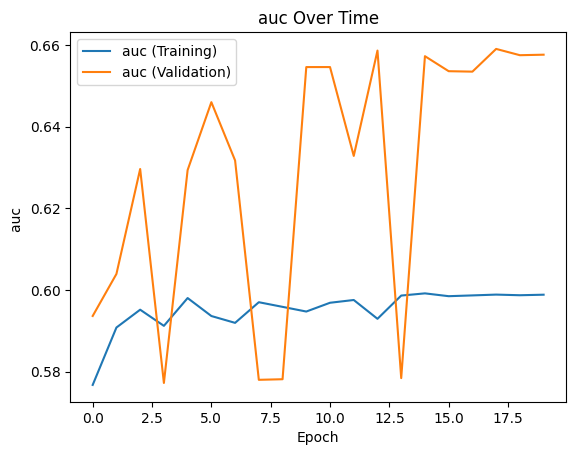

In [ ]:
visualize_metric(lstm_history, 'auc')

Testing the model

In [ ]:
evaluation = lstm_model.evaluate(x=test_data[0], y=test_data[1], sample_weight=mask_test)

1/1 [==============================] - 12s 12s/step - loss: 1.6345 - accuracy: 0.3744 - auc: 0.5914


In [ ]:
predictions = lstm_model.predict(test_data[0])
y_preds = np.argmax(predictions, axis=2)

1/1 [==============================] - 11s 11s/step


In [ ]:
print(f"Test loss : {evaluation[lstm_model.metrics_names.index('loss')]}")
print(f"Test accuracy : {evaluation[lstm_model.metrics_names.index('accuracy')]}")
print(f"Test AUC : {evaluation[lstm_model.metrics_names.index('auc')]}")

Test loss : 1.6344619989395142
Test accuracy : 0.37440410256385803
Test AUC : 0.5914310216903687


In [ ]:
# weighted for multi-class classification
precision = precision_score(np.argmax(test_data[1], axis=2).flatten().astype(np.int32), y_preds.flatten().astype(np.int32), average='weighted')
recall = recall_score(np.argmax(test_data[1], axis=2).flatten().astype(np.int32), y_preds.flatten().astype(np.int32), average='weighted')
f1 = f1_score(np.argmax(test_data[1], axis=2).flatten().astype(np.int32), y_preds.flatten().astype(np.int32), average='weighted')

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Test Precision: 0.2985048716572911
Test Recall: 0.37440410915737066
Test F1 Score: 0.29267449817076263


# BiLSTM architecture

In [13]:
input_shape = (634680, 3)
num_classes = 3
learning_rate=0.001
loss='categorical_crossentropy'
metrics=['accuracy', classif_metrics.AUC(name = 'auc')]

bilstm_model=create_bilstm(input_shape, metrics, learning_rate, loss, num_classes)
bilstm_model.summary()

Model: "BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 634680, 3)]       0         
                                                                 
 masking_1 (Masking)         (None, 634680, 3)         0         
                                                                 
 bidirectional (Bidirection  (None, 634680, 128)       34816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 634680, 64)        41216     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 634680, 32)        10368     
 onal)                                                           
                                                            

In [ ]:
lr = ReduceLROnPlateau(monitor='val_auc', factor=0.4,  patience=3, verbose=True)
es = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True, verbose=True)

In [ ]:
bilstm_history = bilstm_model.fit(
    train_data[0],
    train_data[1],
    epochs=20,
    batch_size=4,
    validation_data=val_data,
    sample_weight=mask_train,
    callbacks=[es,lr]
)

Epoch 1/20
7/7 [==============================] - 602s 85s/step - loss: 1.0850 - accuracy: 0.3323 - auc: 0.5525 - val_loss: 1.0526 - val_accuracy: 0.3513 - val_auc: 0.5788 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - 582s 84s/step - loss: 1.0651 - accuracy: 0.3792 - auc: 0.5843 - val_loss: 1.0511 - val_accuracy: 0.4614 - val_auc: 0.6042 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - 580s 84s/step - loss: 1.0614 - accuracy: 0.3942 - auc: 0.5935 - val_loss: 1.0638 - val_accuracy: 0.3513 - val_auc: 0.5796 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 1.0605 - accuracy: 0.3977 - auc: 0.5953  
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
7/7 [==============================] - 581s 84s/step - loss: 1.0605 - accuracy: 0.3977 - auc: 0.5953 - val_loss: 1.0568 - val_accuracy: 0.3513 - val_auc: 0.5803 - lr: 0.0010
Epoch 5/20
7/7 [==============================] - 580s 84s/step - loss: 1.0585 - accura

In [ ]:
# To save the model
bilstm_model.save('bilstm_24102023.h5')

with open('bilstm_history_24102023.pkl', 'wb') as file:
    pickle.dump(bilstm_history.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# To load the model if already trained

# bilstm_model = load_model('lstm_24102023.h5')
# with open('lstm_history_24102023.pkl', 'rb') as file:
#    lstm_history = pickle.load(file)

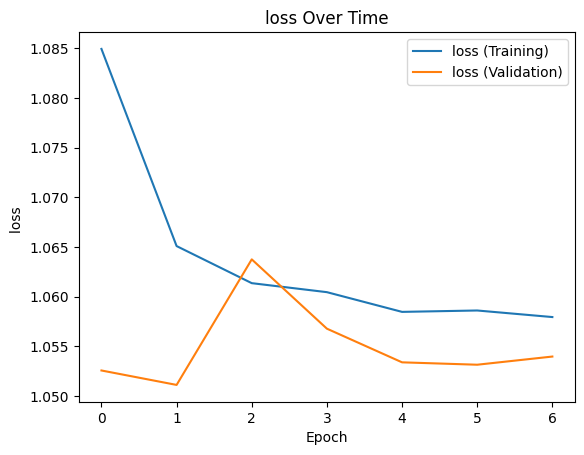

In [ ]:
visualize_metric(bilstm_history, 'loss')

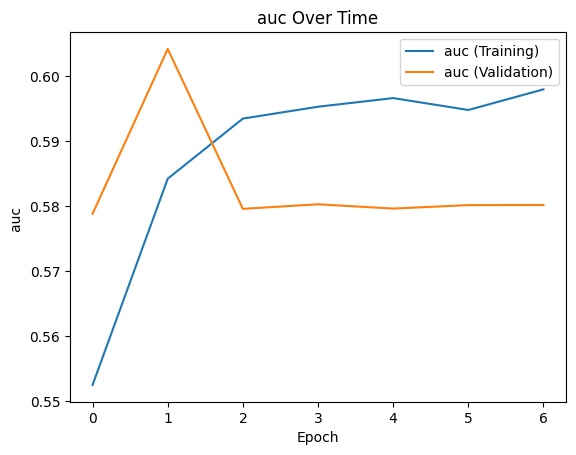

In [ ]:
visualize_metric(bilstm_history, 'auc')

Testing the model...

In [ ]:
evaluation = bilstm_model.evaluate(x=test_data[0], y=test_data[1], sample_weight=mask_test)

1/1 [==============================] - 33s 33s/step - loss: 1.0653 - accuracy: 0.4231 - auc: 0.5914


In [ ]:
predictions = bilstm_model.predict(test_data[0])
y_preds = np.argmax(predictions, axis=2)

1/1 [==============================] - 35s 35s/step


In [ ]:
print(f"Test loss : {evaluation[bilstm_model.metrics_names.index('loss')]}")
print(f"Test accuracy : {evaluation[bilstm_model.metrics_names.index('accuracy')]}")
print(f"Test AUC : {evaluation[bilstm_model.metrics_names.index('auc')]}")

Test loss : 1.0652706623077393
Test accuracy : 0.4230903685092926
Test AUC : 0.591446578502655


In [ ]:
# weighted for multi-class classification
precision = precision_score(np.argmax(test_data[1], axis=2).flatten().astype(np.int32), y_preds.flatten().astype(np.int32), average='weighted')
recall = recall_score(np.argmax(test_data[1], axis=2).flatten().astype(np.int32), y_preds.flatten().astype(np.int32), average='weighted')
f1 = f1_score(np.argmax(test_data[1], axis=2).flatten().astype(np.int32), y_preds.flatten().astype(np.int32), average='weighted')

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Precision: 0.44606205347196
Test Recall: 0.4230903762525997
Test F1 Score: 0.2624254980480625


# CNN+LSTM Network architecture

In [14]:
input_shape = (634680, 3)
num_classes = 3
learning_rate=0.001
loss='categorical_crossentropy'
metrics=['accuracy', classif_metrics.AUC(name = 'auc')]

lstmcnn_model=create_lstmcnn(input_shape, metrics, learning_rate, loss, num_classes)
lstmcnn_model.summary()

Model: "CNN-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 634680, 3)]       0         
                                                                 
 masking_2 (Masking)         (None, 634680, 3)         0         
                                                                 
 conv1d (Conv1D)             (None, 634680, 16)        24592     
                                                                 
 dropout_3 (Dropout)         (None, 634680, 16)        0         
                                                                 
 batch_normalization (Batch  (None, 634680, 16)        64        
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 634680, 16)        65552     
                                                          

In [ ]:
lr = ReduceLROnPlateau(monitor='val_auc', factor=0.4,  patience=3, verbose=True)
es = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True, verbose=True)

In [ ]:
lstmcnn_history = lstmcnn_model.fit(
    train_data[0],
    train_data[1],
    epochs=20,
    batch_size=4,
    validation_data=val_data,
    sample_weight=mask_train,
    callbacks=[es,lr]
)

Epoch 1/20
7/7 [==============================] - 135s 19s/step - loss: 1.0500 - accuracy: 0.5514 - auc: 0.7536 - val_loss: 1.1647 - val_accuracy: 0.2990 - val_auc: 0.4459 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - 130s 19s/step - loss: 0.7845 - accuracy: 0.6715 - auc: 0.8557 - val_loss: 1.1311 - val_accuracy: 0.3145 - val_auc: 0.5630 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - 130s 19s/step - loss: 0.7570 - accuracy: 0.6674 - auc: 0.8467 - val_loss: 1.1802 - val_accuracy: 0.3090 - val_auc: 0.5206 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 0.7354 - accuracy: 0.6731 - auc: 0.8567 
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
7/7 [==============================] - 130s 19s/step - loss: 0.7354 - accuracy: 0.6731 - auc: 0.8567 - val_loss: 1.2453 - val_accuracy: 0.2689 - val_auc: 0.4863 - lr: 0.0010
Epoch 5/20
7/7 [==============================] - 130s 19s/step - loss: 0.7334 - accurac

In [ ]:
# To save the model
lstmcnn_model.save('cnn_lstm_24102023.h5')

with open('cnn_lstm_history_24102023.pkl', 'wb') as file:
    pickle.dump(lstmcnn_history.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# To load the model if already trained

# lstmcnn_model = load_model('cnn_lstm_24102023.h5')
# with open('cnn_lstm_history_24102023.pkl', 'rb') as file:
#    lstmcnn_history = pickle.load(file)

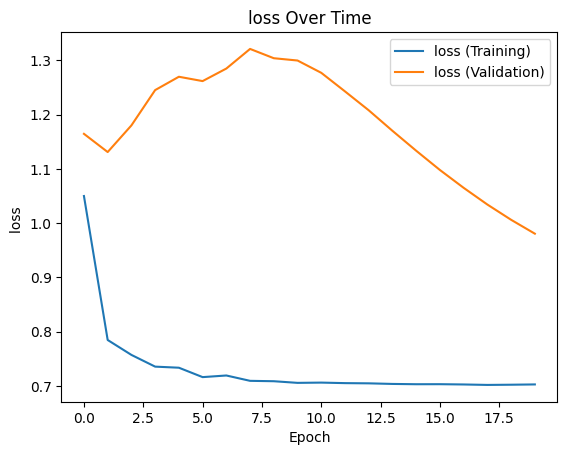

In [ ]:
visualize_metric(lstmcnn_history, 'loss')

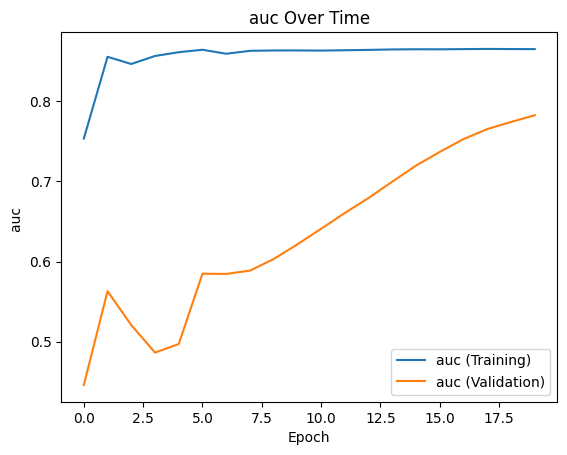

In [ ]:
visualize_metric(lstmcnn_history, 'auc')

Testing the model

In [ ]:
evaluation = lstmcnn_model.evaluate(x=test_data[0], y=test_data[1], sample_weight=mask_test)

1/1 [==============================] - 7s 7s/step - loss: 0.7429 - accuracy: 0.6828 - auc: 0.8559


In [ ]:
predictions = lstmcnn_model.predict(test_data[0])
y_preds = np.argmax(predictions, axis=2)

1/1 [==============================] - 8s 8s/step


In [ ]:
print(f"Test loss : {evaluation[lstmcnn_model.metrics_names.index('loss')]}")
print(f"Test accuracy : {evaluation[lstmcnn_model.metrics_names.index('accuracy')]}")
print(f"Test AUC : {evaluation[lstmcnn_model.metrics_names.index('auc')]}")

Test loss : 0.7429226636886597
Test accuracy : 0.6828058362007141
Test AUC : 0.8559109568595886


In [ ]:
# weighted for multi-class classification
precision = precision_score(np.argmax(test_data[1], axis=2).flatten().astype(np.int32), y_preds.flatten().astype(np.int32), average='weighted')
recall = recall_score(np.argmax(test_data[1], axis=2).flatten().astype(np.int32), y_preds.flatten().astype(np.int32), average='weighted')
f1 = f1_score(np.argmax(test_data[1], axis=2).flatten().astype(np.int32), y_preds.flatten().astype(np.int32), average='weighted')

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Precision: 0.534661466692988
Test Recall: 0.6828058234070713
Test F1 Score: 0.5993696022485042


# CNN+BiLSTM architecture

In [15]:
input_shape = (634680, 3)
num_classes = 3
learning_rate=0.001
loss='categorical_crossentropy'
metrics=['accuracy', classif_metrics.AUC(name = 'auc')]

bilstmcnn_model=create_bilstmcnn(input_shape, metrics, learning_rate, loss, num_classes)
bilstmcnn_model.summary()

Model: "CNN-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 634680, 3)]       0         
                                                                 
 masking_3 (Masking)         (None, 634680, 3)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 634680, 16)        24592     
                                                                 
 dropout_8 (Dropout)         (None, 634680, 16)        0         
                                                                 
 batch_normalization_5 (Bat  (None, 634680, 16)        64        
 chNormalization)                                                
                                                                 
 conv1d_5 (Conv1D)           (None, 634680, 16)        65552     
                                                          

In [ ]:
lr = ReduceLROnPlateau(monitor='val_auc', factor=0.4,  patience=3, verbose=True)
es = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True, verbose=True)

In [ ]:
bilstmcnn_history = bilstmcnn_model.fit(
    train_data[0],
    train_data[1],
    epochs=20,
    batch_size=4,
    validation_data=val_data,
    sample_weight=mask_train,
    callbacks=[es,lr]
)

Epoch 1/20
7/7 [==============================] - 243s 33s/step - loss: 0.9814 - accuracy: 0.5885 - auc: 0.7835 - val_loss: 1.2116 - val_accuracy: 0.4610 - val_auc: 0.5550 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - 218s 32s/step - loss: 0.8159 - accuracy: 0.6509 - auc: 0.8440 - val_loss: 1.1530 - val_accuracy: 0.4785 - val_auc: 0.5738 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - 218s 32s/step - loss: 0.7838 - accuracy: 0.6671 - auc: 0.8512 - val_loss: 1.2432 - val_accuracy: 0.4915 - val_auc: 0.5233 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - 218s 32s/step - loss: 0.7541 - accuracy: 0.6686 - auc: 0.8535 - val_loss: 1.2545 - val_accuracy: 0.5007 - val_auc: 0.5464 - lr: 0.0010
Epoch 5/20
7/7 [==============================] - 218s 32s/step - loss: 0.7400 - accuracy: 0.6740 - auc: 0.8561 - val_loss: 1.2972 - val_accuracy: 0.5109 - val_auc: 0.5395 - lr: 0.0010
Epoch 6/20
7/7 [==============================] - ETA: 0s - loss: 0.7267 - 

In [ ]:
# To save the model
bilstmcnn_model.save('cnn_bilstm_24102023.h5')

with open('cnn_bilstm_history_24102023.pkl', 'wb') as file:
    pickle.dump(bilstmcnn_history.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# To load the model if already trained

# bilstmcnn_model = load_model('cnn_bilstm_24102023.h5')
# with open('cnn_bilstm_history_24102023.pkl', 'rb') as file:
#    bilstmcnn_history = pickle.load(file)

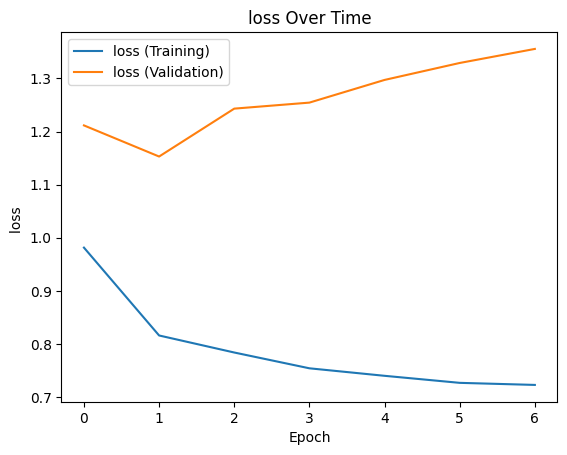

In [ ]:
visualize_metric(bilstmcnn_history, 'loss')

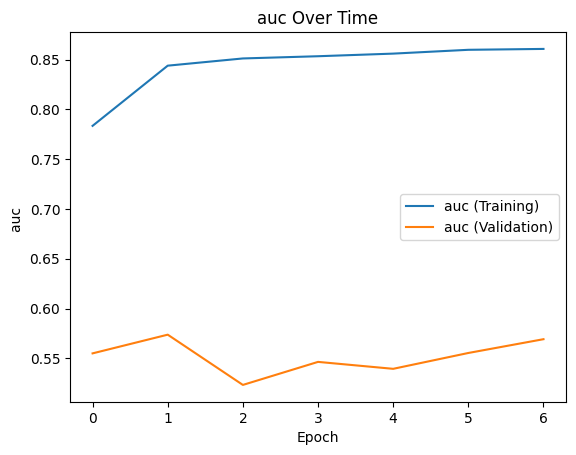

In [ ]:
visualize_metric(bilstmcnn_history, 'auc')

In [ ]:
evaluation = bilstmcnn_model.evaluate(x=test_data[0], y=test_data[1],sample_weight=mask_test)

1/1 [==============================] - 17s 17s/step - loss: 1.2187 - accuracy: 0.4429 - auc: 0.5167


In [ ]:
predictions = bilstmcnn_model.predict(test_data[0])
y_preds = np.argmax(predictions, axis=2)

1/1 [==============================] - 13s 13s/step


In [ ]:
print(f"Test loss : {evaluation[bilstmcnn_model.metrics_names.index('loss')]}")
print(f"Test accuracy : {evaluation[bilstmcnn_model.metrics_names.index('accuracy')]}")
print(f"Test AUC : {evaluation[bilstmcnn_model.metrics_names.index('auc')]}")

Test loss : 1.2186599969863892
Test accuracy : 0.4428552985191345
Test AUC : 0.5166650414466858


In [ ]:
# weighted for multi-class classification
precision = precision_score(np.argmax(test_data[1], axis=2).flatten().astype(np.int32), y_preds.flatten().astype(np.int32), average='weighted')
recall = recall_score(np.argmax(test_data[1], axis=2).flatten().astype(np.int32), y_preds.flatten().astype(np.int32), average='weighted')
f1 = f1_score(np.argmax(test_data[1], axis=2).flatten().astype(np.int32), y_preds.flatten().astype(np.int32), average='weighted')

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Precision: 0.42700859066284025
Test Recall: 0.44285529715762273
Test F1 Score: 0.3019743507360834
